In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
diamond_df = pd.read_csv('data/diamonds.csv', index_col=0)
diamond_df.head(20)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [3]:
diamond_df.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [4]:
diamond_df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [5]:
diamond_df.shape

(53940, 10)

Data Preparation

In [6]:
diamond_df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [7]:
diamond_df.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [8]:
diamond_df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

What’s more, a little bit of internet digging will show you that the values present in these variables have an intrinsic hierarchy to them. Each diamond has a Cut, Color, and Clarity rating on a scale. For Cut, the scale(from highest to lowest) is Ideal>Premium>Very Good>Good>Fair.

Because of this hierarchy, we can call these ordinal categorical variables. We have to encode them according to the inherent scale if we want to appropriately capture the information in numeric form.

The easiest way to do this with so few categories in each variable is with mapping, but scikit-learn also has an OrdinalEncoder class:

In [9]:
# Encode the ordinal categorical variable 'cut'
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
diamond_df.cut = diamond_df.cut.map(cut_mapping)

# Encoding the ordinal categorical variable 'color'
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
diamond_df.color = diamond_df.color.map(color_mapping)

# Encoding the ordinal cateogircal variable 'clarity'
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diamond_df.clarity = diamond_df.clarity.map(clarity_mapping)

Once we’ve encoded the ordinal variables, let’s get rid of any outliers and/or nonsense data.

First, any observations with an X,Y, or Z dimension of 0 are getting the ax:

In [10]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["x"]==0].index)

In [11]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["y"]==0].index)

In [12]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["z"]==0].index)

Then, we’ll cut the dataset down to the 99th percentile based on a few different variables to get rid of the most egregious outliers. This is by no means a nuanced approach to handling outliers and a lot more effort would be put into this portion of the work in a real-world scenario:



In [13]:
diamond_df = diamond_df[diamond_df['depth'] < diamond_df['depth'].quantile(0.99)]

In [14]:
diamond_df = diamond_df[diamond_df['table'] < diamond_df['table'].quantile(0.99)]

In [15]:
diamond_df = diamond_df[diamond_df['x'] < diamond_df['x'].quantile(0.99)]

In [16]:
diamond_df = diamond_df[diamond_df['y'] < diamond_df['y'].quantile(0.99)]

In [17]:
diamond_df = diamond_df[diamond_df['z'] < diamond_df['z'].quantile(0.99)]

Now that the data is all prepped for modeling, let’s take a look at a correlation heatmap to see what features we can expect to influence price and how:

/tmp/ipykernel_3709/3692349902.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


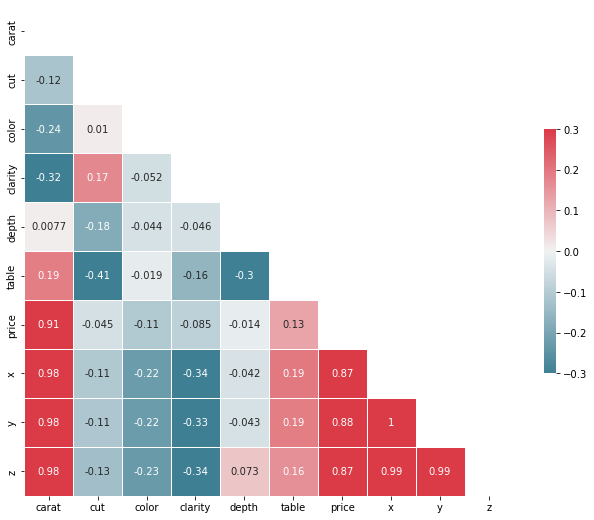

In [18]:
# Create the correlation matrix
corr = diamond_df.corr()

# Generate mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ration
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            annot=True,
            vmax=.3,
            vmin=-.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5});

### Creating the Model
First off we’ll do the standard train/validation/test split:

In [19]:
model_df = diamond_df.copy()
X = model_df.drop(['price'], axis=1)
y = model_df['price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

Now, because this is mainly to demonstrate productionizing of the ML model using streamlit, I’m going to throw a GridSearchCV at an XGBoost Regressor to come up with an optimal fit quickly. Again, don’t do this in a real-world scenario, it’s uncouth (it also takes a very long time to run):

In [20]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=0)

xgb_grid.fit(X_train, y_train)

xgb_cv = (xgb_grid.best_estimator_)

eval_set = [(X_train, y_train),
            (X_val, y_val)]

fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

/home/nicholas/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/nicholas/.local/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE: 235.76115356600496
MSE: 196555.23133762396
R2: 0.9835076894068906
